# Compare iJL1678b-ME and iEco1689-ME

Code for reproducing panels of Figure 2: 2a, 2b, and 2c

## Setup environment

In [1]:
import coralme
from coralme.builder.helper_functions import *
import pickle
import pandas
import os
import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np
import sympy
pandas.set_option('display.max_colwidth', None)
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import pickle, tqdm
with open('./published/ecoli/MEModel-step2-ecoli.pkl', 'rb') as infile:
    me = pickle.load(infile)

me.add_boundary(me.metabolites.li_c, type = 'sink');

me.optimize(max_mu = 1.0)
sol = me.solution.to_frame()['fluxes']
sol.to_csv('./published/ecoli/fluxes_ecoli_uME-model.txt', sep = '\t', header = False)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01
Read LP format model from file /tmp/tmpqbcs3pev.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp57n_suti.lp
Reading time = 0.01 seconds
: 1660 rows, 4754 columns, 17902 nonzeros
Read LP format model from file /tmp/tmpc85f69w6.lp
Reading time = 0.01 seconds
: 1810 rows, 5220 columns, 17878 nonzeros
The MINOS and quad MINOS solvers are a courtesy of Prof Michael A. Saunders. Please cite Ma, D., Yang, L., Fleming, R. et al. Reliable and efficient solution of genome-scale models of Metabolism and macromolecular Expression. Sci Rep 7, 40863 (2017). https://doi.org/10.1038/srep40863

Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Optimal
        3	0.8750000000000000	Not feasible
        4	0.8125000000000000	Optimal
        5	0.8437500000000000	No

In [3]:
# new reaction names, manually curated
with open('./published/ecoli/paper/ecolime-new-reaction-names.txt', 'r') as infile:
    rxn_names = pandas.read_csv(infile, sep = '\t', header = None, index_col = 0)
# rxn_names.index

# simulation from original ecolime, solvemepy and qminos. default tolerance 1e-6
with open('./published/ecoli/paper/ecolime-fluxes-from-model.txt', 'r') as infile:
    source = pandas.read_csv(infile, sep = '\t', header = None, index_col = 0)

source.index = rxn_names.index
source.columns = ['cobrame fluxes']
# source[source['cobrame fluxes'] != 0] # 2363 non-zero fluxes

In [4]:
# simulation of model using coralme and qminos. default tolerance 1e-6
with open('./published/ecoli/fluxes_ecoli_uME-model.txt', 'r') as infile:
    target = pandas.read_csv(infile, sep = '\t', header = None, index_col = 0)

# remove location of translocated proteins to match ecolime model reactions
dct = { x:x.replace('_Outer_Membrane', '').replace('_Inner_Membrane', '').replace('_Periplasm', '').replace('_Membrane', '')
       for x in target.index if x.startswith('translocation') }

target.index = [ dct.get(x, x) for x in target.index ]
target.columns = ['coralme fluxes']
# target[target['coralme fluxes'] != 0] # 2436 non-zero fluxes

In [5]:
# identify mismatching reactions
tmp = pandas.concat([source['cobrame fluxes'], target['coralme fluxes']], axis = 1)
tmp = tmp[tmp['cobrame fluxes'].isna() | tmp['coralme fluxes'].isna()].sort_index()

# identify differences and save
tmp[~tmp.index.str.startswith('transcription_') & 
    ~tmp.index.str.startswith('translocation_')].to_csv('mismatching_reactions.txt', sep = '\t')

tmp[~tmp.index.str.startswith('transcription_') & 
    ~tmp.index.str.startswith('translocation_') & 
    (tmp['cobrame fluxes'] != 0) & 
    (tmp['coralme fluxes'] != 0)].to_csv('mismatching_reactions_nonzeros.txt', sep = '\t')

tmp[tmp.index.str.startswith('transcription_')].to_csv('mismatching_reactions_transcription_only.txt', sep = '\t')
tmp[tmp.index.str.startswith('translocation_')].to_csv('mismatching_reactions_translocation_only.txt', sep = '\t')

In [6]:
# concatenation will align reaction names
tmp = pandas.concat([source['cobrame fluxes'], target['coralme fluxes']], axis = 1)
total = tmp.dropna(how = 'any').shape[0]

In [7]:
tmp[tmp['coralme fluxes'].isna()].shape[0] # unique reactions in COBRAme

26

In [8]:
tmp[tmp['coralme fluxes'].isna() & (tmp['cobrame fluxes'] != 0)].shape[0] # non-zero flux and unique reactions

6

In [9]:
tmp[tmp['cobrame fluxes'].isna()].shape[0] # unique reactions in coralME

2328

In [10]:
tmp[tmp['cobrame fluxes'].isna() & (tmp['coralme fluxes'] != 0)].shape[0] # non-zero flux and unique reactions

85

In [11]:
max(abs(tmp['cobrame fluxes'] - tmp['coralme fluxes']))

0.760026912277791

In [12]:
# concatenation will align reaction names
tmp = pandas.concat([source['cobrame fluxes'], target['coralme fluxes']], axis = 1).dropna(how = 'any')
total = tmp.shape[0]

from scipy.stats import linregress
res1 = linregress(tmp.iloc[:, 0], tmp.iloc[:, 1])
print(res1)

tmp = tmp[(tmp['cobrame fluxes'] != 0) & (tmp['coralme fluxes'] != 0)]
res2 = linregress(tmp.iloc[:, 0], tmp.iloc[:, 1])
print(res2)

tmp = tmp[(tmp['cobrame fluxes'] != 0) & (tmp['coralme fluxes'] != 0)]
res3 = linregress(tmp.iloc[:, 0].apply(abs).apply(np.log), tmp.iloc[:, 1].apply(abs).apply(np.log))
print(res3)

LinregressResult(slope=0.9870847097941821, intercept=-4.413699385651115e-05, rvalue=0.999780710466049, pvalue=0.0, stderr=0.00018399233070169762, intercept_stderr=0.0001916631669784639)
LinregressResult(slope=0.9871080705992674, intercept=-0.00022321325380664225, rvalue=0.9997919404941055, pvalue=0.0, stderr=0.00041802638000104116, intercept_stderr=0.001015310949581336)
LinregressResult(slope=0.9955676080129845, intercept=-0.05578440082375202, rvalue=0.9987838107862137, pvalue=0.0, stderr=0.0010201057103267392, intercept_stderr=0.015729227094163394)


In [13]:
non_zero_fluxes = tmp[(tmp['cobrame fluxes'] != 0) & (tmp['coralme fluxes'] != 0)] # 2323 non-zero fluxes
total, total - non_zero_fluxes.shape[0], non_zero_fluxes.shape[0]

(12629, 10306, 2323)

In [14]:
non_zero_fluxes[abs(non_zero_fluxes['cobrame fluxes'] - non_zero_fluxes['coralme fluxes']) < 0.01] # 2232

,cobrame fluxes,coralme fluxes
protein_biomass_to_biomass,3.294974e-01,3.243568e-01
mRNA_biomass_to_biomass,2.758172e-03,2.682268e-03
tRNA_biomass_to_biomass,1.674525e-02,1.628470e-02
rRNA_biomass_to_biomass,1.196234e-01,1.163320e-01
ncRNA_biomass_to_biomass,1.883306e-04,1.914105e-04
...,...,...
b2477_lipid_modification_pg120_p_pe160_p,3.730841e-06,3.560668e-06
b2595_lipid_modification_pg120_p_pe160_p,3.730841e-06,3.560668e-06
b2617_lipid_modification_pg120_p_pe160_p,3.730841e-06,3.560668e-06
b1677_lipid_modification_pg120_p_pe160_p,2.997369e-03,2.944603e-03


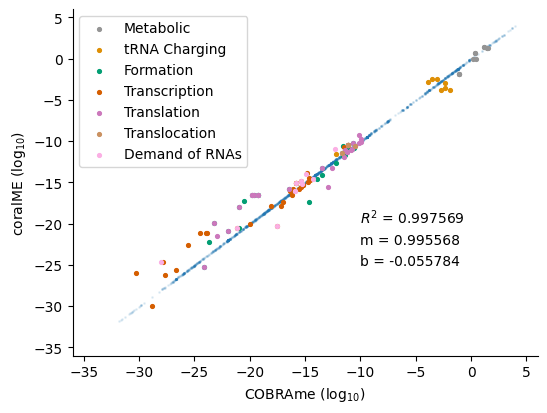

In [15]:
import seaborn

palette = seaborn.color_palette('colorblind', 10)

# concatenation will align reaction names
tmp = pandas.concat([source['cobrame fluxes'], target['coralme fluxes']], axis = 1).dropna(how = 'any')

# plot non-zero fluxes only
tmp = tmp[(tmp['cobrame fluxes'] != 0) & (tmp['coralme fluxes'] != 0)]
fig, ax = plt.subplots(1, 1, figsize = (4*1.5, 3*1.5), dpi = 100)

tmp3 = tmp.apply(abs).apply(np.log)
tmp3['delta'] = tmp3['cobrame fluxes'] - tmp3['coralme fluxes']

tmp3[abs(tmp3['delta']) < 0.1].plot(kind = 'scatter', x = 0, y = 1, ax = ax, alpha = .1, s = 1.)

tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.contains('_REV_|_FWD_') & 
     ~tmp3.index.str.contains('dummy_reaction_FWD_SPONT')]\
.plot(kind = 'scatter', x = 0, y = 1, ax = ax, s = 7.5, color = palette[7], label = 'Metabolic')
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('charging')]\
.plot(kind = 'scatter', x = 0, y = 1, ax = ax, s = 7.5, color = palette[1], label = 'tRNA Charging')
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('formation')]\
.plot(kind = 'scatter', x = 0, y = 1, ax = ax, s = 7.5, color = palette[2], label = 'Formation')
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('transcription')]\
.plot(kind = 'scatter', x = 0, y = 1, ax = ax, s = 7.5, color = palette[3], label = 'Transcription')
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('translation')]\
.plot(kind = 'scatter', x = 0, y = 1, ax = ax, s = 7.5, color = palette[4], label = 'Translation')
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('translocation')]\
.plot(kind = 'scatter', x = 0, y = 1, ax = ax, s = 7.5, color = palette[5], label = 'Translocation')
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('DM_RNA')]\
.plot(kind = 'scatter', x = 0, y = 1, ax = ax, s = 7.5, color = palette[6], label = 'Demand of RNAs')

plt.text(-10, -20, '$R^2$ = {:f}'.format(res3[2]**2))
plt.text(-10, -22.5, 'm = {:f}'.format(res3[0]))
plt.text(-10, -25, 'b = {:f}'.format(res3[1]))
    
plt.xlim(-36, 6)
plt.ylim(-36, 6)

ax.set_xlabel(r'COBRAme (log$_{10}$)')
ax.set_ylabel(r'coralME (log$_{10}$)')

seaborn.despine()

plt.savefig('figures/flux_comparison_linear_regression_log10_outliers.svg',format='SVG')

In [16]:
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.contains('_REV_|_FWD_') & 
     ~tmp3.index.str.contains('dummy_reaction_FWD_SPONT')].shape[0] + \
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('charging')].shape[0] + \
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('formation')].shape[0] + \
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('transcription')].shape[0] + \
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('translation')].shape[0] + \
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('translocation')].shape[0] + \
tmp3[(abs(tmp3['delta']) >= 0.1) & tmp3.index.str.startswith('DM_RNA')].shape[0]

130

In [17]:
tmp['log cobrame fluxes'] = tmp['cobrame fluxes'].apply(np.log10)
tmp['log coralme fluxes'] = tmp['coralme fluxes'].apply(np.log10)

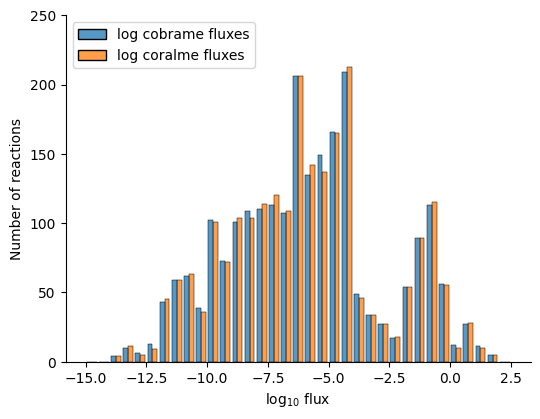

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (4*1.5, 3*1.5), dpi = 100)
seaborn.histplot(
    tmp[['log cobrame fluxes', 'log coralme fluxes']], ax = ax, 
    multiple="dodge", shrink=.8, binrange = (-15, +2.5), binwidth = .5)#, element="step", fill=False, kde = True)

ax.set_xlabel(r'log$_{10}$ flux')
ax.set_ylabel('Number of reactions')
ax.set_ylim(0, 250)

seaborn.despine()

plt.savefig('figures/flux_comparison_histogram.svg',format='SVG')

In [19]:
tmp['FC'] = tmp['coralme fluxes'] / tmp['cobrame fluxes']
tmp['log2FC'] = np.log2(tmp['FC'])
tmp['log2FC'].min(), tmp['log2FC'].max() # (-1.1817633001001462, 1.8772849979992727)
tmp.sort_values('log2FC')

,cobrame fluxes,coralme fluxes,log cobrame fluxes,log coralme fluxes,FC,log2FC
formation_DEOD-CPLX,4.222186e-07,2.775781e-08,-6.374463,-7.556615,0.065743,-3.927025
translation_b4384,2.533311e-06,1.665468e-07,-5.596311,-6.778464,0.065743,-3.927025
transcription_TU0_6646_with_TERM88_from_RpoD_mono,2.381595e-08,1.572848e-09,-7.623132,-8.803313,0.066042,-3.920477
DM_RNA_b4383,2.381600e-08,1.572898e-09,-7.623131,-8.803300,0.066044,-3.920435
charging_tRNA_b3277_AUC,1.428565e-01,2.397347e-02,-0.845100,-1.620269,0.167815,-2.575056
...,...,...,...,...,...,...
translation_b2891,2.569760e-09,6.675885e-08,-8.590107,-7.175491,25.978626,4.699253
formation_PrfB_mono,2.569760e-09,6.675885e-08,-8.590107,-7.175491,25.978626,4.699253
transcription_TU00324_from_RpoD_mono,2.415866e-11,6.304823e-10,-10.616927,-9.200327,26.097563,4.705843
DM_RNA_b1210,6.946195e-13,1.997699e-11,-12.158253,-10.699470,28.759625,4.845973


In [20]:
ranges = [ int('{:d}'.format(x)) for x in range(-5, +5) ]
# ranges

counts = []
for idx, limit in enumerate(ranges[:-1]):
    counts.append([limit, tmp['log2FC'].between(ranges[idx], ranges[idx+1]).sum()])
    
df = pandas.DataFrame(counts, columns = ['lower limit', 'count'])
df['relative'] = df['count'] / df['count'].sum() * 100
df['cumsum'] = df['relative'].cumsum()
df['count'].sum()
df.sum()

lower limit      -9.000000
count          2307.000000
relative        100.000000
cumsum          492.587776
dtype: float64

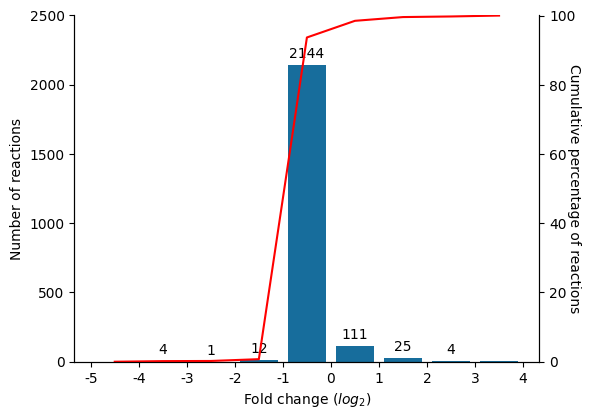

In [21]:
seaborn.set_palette('colorblind')

fig, ax1 = plt.subplots(1, 1, figsize = (4*1.5, 3*1.5), dpi = 100)
plots = seaborn.barplot(data = df, x = 'lower limit', y = 'count', palette = seaborn.color_palette('colorblind', 1))

for bar in plots.patches[1:-1]:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 8), textcoords = 'offset points')

ax1.set_xticklabels(ax1.get_xticklabels())#, rotation = 90)
ax1.set_ylim(0, 2500.4)
ax1.set_xlabel('Fold change ($log_{2}$)')
ax1.set_ylabel('Number of reactions')
ax1.set_xticks([ x-0.5 for x in range(0, 10) ], [ int('{:d}'.format(x)) for x in range(-5, +5) ])
# ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(df['cumsum'], c = 'red')
ax2.set_ylim(0, 100.1)
ax2.set_ylabel('Cumulative percentage of reactions', rotation = 270)

seaborn.despine(right = False)

plt.savefig('figures/flux_comparison_histogram_log2foldchange.svg',format='SVG')

In [22]:
# Maximum growth rate (Supplementary Table S1)
sol.loc['biomass_dilution']

0.8186273574829102

In [23]:
# Regeneration of the LipA accessory iron-sulfur cluster (Supplementary Table S1)
sol.loc['CPLX0-782_mod_4fe4s(2)_regeneration_FWD_SPONT']

9.862705551525972e-07

In [24]:
# Lipoyl biosynthesis (Supplementary Table S1)
sol.loc['formation_2OXOGLUTARATEDEH-CPLX_mod_mg2(1)_mod_lipoyl(1)_lipoyl_denovo_corrected']

3.433783854820657e-07

In [25]:
# Lipoyl biosynthesis (Supplementary Table S1)
sol.loc['formation_PYRUVATEDEH-CPLX_mod_mg2(1)_mod_fad(1)_mod_thmpp(1)_mod_lipoyl(1)_lipoyl_denovo_corrected']

6.428921696705315e-07

In [26]:
# Dipyrromethane (DPM) biosynthesis (Supplementary Table S1)
sol.loc['DPM_FWD_CPLX_dummy']

9.564605535745636e-11

In [27]:
# holo-ACP biosynthesis (Supplementary Table S1)
sol.loc['formation_EG50003-MONOMER_mod_pan4p(1)']

2.970963829622795e-06